In [1]:
'''Line up the peak (by offsetting the peak,
or just throw away data before the peak) --DONE
Filter out data with large gap
Use the maximum date as input --DONE
Weighted loss
Labeling the lightcurve for different type of supernova
Interpolation that taken account in the non-uniform timestep? --DONE
Feed the output back as input to see anything reasonable --DONE
Throw away data without a rising peak (calculate the average nemerical slope before the maximum) --DONE
Truncate the no. of days --DONE
Try using relative physical date as input (don't need to interpolate for uniform step in this way?) --DONE
Smoothing the interpolation by taking average
Just use one telescope? --DONE
Try multiple band?
See see the output from the encoding part
Philips relation from the output --DONE
Dropout layer (much worse learning as predicted) --DONE
Training and predicting with lightcurve with large data gaps'''

"Line up the peak (by offsetting the peak,\nor just throw away data before the peak) --DONE\nFilter out data with large gap\nUse the maximum date as input --DONE\nWeighted loss\nLabeling the lightcurve for different type of supernova\nInterpolation that taken account in the non-uniform timestep? --DONE\nFeed the output back as input to see anything reasonable --DONE\nThrow away data without a rising peak (calculate the average nemerical slope before the maximum) --DONE\nTruncate the no. of days --DONE\nTry using relative physical date as input (don't need to interpolate for uniform step in this way?) --DONE\nSmoothing the interpolation by taking average\nJust use one telescope? --DONE\nTry multiple band?\nSee see the output from the encoding part\nPhilips relation from the output --DONE\nDropout layer (much worse learning as predicted) --DONE\nTraining and predicting with lightcurve with large data gaps"

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d, splrep

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Layer, Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.optimizers import Adam
import keras.backend as K
from keras.losses import mean_squared_error
import tensorflow as tf

In [3]:
# Import the .json file

os.chdir(r"C:\Users\ricky\JupyterNotebooks\Intern21\import_photometry_data\typeIa_photometry")
filename = glob.glob('*.json')
np.random.shuffle(filename)
print(filename)

# Create a list for all .json, the 1st SN saved as json_data[0], the 2nd SN saved as json_data[1], etc.
json_data = []
for i in filename:
    with open(i, encoding="utf-8") as f:
        json_data.append(json.load(f))

['SN2012cg.json', 'SN2005ag.json', 'SN2016hvl.json', 'SN2005el.json', 'SN2017hbi.json', 'SN2002fk.json', 'SN2001el.json', 'SN2012ht.json', 'SN2006ax.json', 'SN2017drh.json', 'SN2016dxv.json', 'SN1990N.json', 'SN2016coj.json', 'SN2016fbo.json', 'SN2005hc.json', 'SN1980N.json', 'SN2015F.json', 'SN2013aa.json', 'SN2009an.json', 'SN2007sr.json', 'SN2019kg.json', 'SN2011fe.json', 'SN2005cf.json', 'SN2000E.json', 'SN2004gs.json', 'SN2012hr.json', 'SN2007if.json', 'SN2011by.json', 'SN2018bac.json', 'SN2017fgc.json', 'SN2008hs.json', 'SN2005na.json', 'SN2007af.json', 'SN1994ae.json', 'SN2006le.json', 'SN2012fr.json', 'SN2008C.json', 'SN2002er.json', 'SN2016dxj.json', 'SN1999ee.json', 'SN1994D.json', 'SN1989B.json', 'SN2017erp.json', 'SN2005am.json', 'SN1998bu.json', 'SN2013gh.json', 'SN2006D.json', 'SN1937C.json', 'SN2013gy.json', 'SN2007on.json', 'SN2000cx.json', 'SN2003du.json', 'SN2008hv.json', 'SN1981B.json', 'SN2005ki.json', 'SN1972E.json', 'SN2018gv.json', 'SN2004eo.json', 'SN2003cg.json

In [4]:
'''To obtain absolute magnitude and time in a particular band.
For every SN.json, there may be multiple sources even within one light band,
at the end this cell will return a list of time and magnitude for every source of the same band'''

Band = [] # Contain EM band chosen for analysis
Magnitude_Abs = [] # Contain absolute magnitude
Time = [] # Contain time (day)
Type = [] # Claimed type
Sample_Count = 0 # Number of light curves obtained


for i in range(len(filename)): # Loop through all SN
    
    Source = [] # Contain different sources within a single .json
    
    Band.append([]) # Create 2D list
    
    SN_name = filename[i].replace('.json', '')
    SN_name = SN_name.replace('_', ':')
    
    Type.append(json_data[i][SN_name]['claimedtype'][0]['value'])
    
    N = len(json_data[i][SN_name]['photometry']) # The no. of data point of photometry in each SN

    for j in range(N): # Loop through all photemetry datapoint in one SN
        # Avoid any data point without band data
        try:
            Band[i].append(json_data[i][SN_name]['photometry'][j]['band'])
        except:
            Band[i].append(0)
        
        # Fill the Magnitude_Abs and Time list if the data point is in B band
        if Band[i][j] == 'B':
            
            Source.append(json_data[i][SN_name]['photometry'][j]['source']) # Obtain the sources
            Source = list(set(Source)) # Remove repetitive sources
            
    if len(Source) == 0: # Avoid empty sources
        Source.append('0') 
            
    
    # Create light curves for every sources
    for k in range(len(Source)):
        for j in range(N): # Loop through all photemetry datapoint in one source
            if (Band[i][j] == 'B') & (json_data[i][SN_name]['photometry'][j]['source'] == Source[k]):
                Magnitude_App = float(json_data[i][SN_name]['photometry'][j]['magnitude']) # Obtain the apparent magnitude from photometry
                LumDist = float(json_data[i][SN_name]['lumdist'][0]['value']) # Obtain the luminosity distance
                z = float(json_data[i][SN_name]['redshift'][0]['value']) # Obtain the redshift, z
                
                Magnitude_Abs.append([]) # Create 2D list
                Time.append([])
                
                Magnitude_Abs[Sample_Count].append(Magnitude_App - 5*np.log10(LumDist*1e5) + 2.5*np.log10(1+z)) # Calculate the absolute magnitude and fill the Magnitude_Abs list
                Time[Sample_Count].append(float(json_data[i][SN_name]['photometry'][j]['time'])) # Fill the Time list
                
        Sample_Count += 1
    
    #print(Source)
print(Sample_Count)
print(len(filename))
print(len(Time))
print(len(Magnitude_Abs))

198
60
[56065.7186, 56065.7637, 56065.8517, 56065.8979, 56067.0356, 56067.1022, 56067.1698, 56067.2377, 56067.302, 56067.3695, 56071.3131, 56071.3801, 56071.4474, 56073.4547, 56073.4553, 56073.5911, 56080.6769, 56082.4087, 56084.6991, 56086.4232, 56088.2201, 56094.2368, 56094.4383, 56114.026, 56114.828, 56118.1594, 56118.225, 56126.3778, 56126.4465, 56130.4284, 56252.3983, 56254.5325, 56411.4988, 56416.845, 56419.8884]


The maximum lightcurve length is 125
[0, 2, 6, 8, 10, 12, 13, 14, 15, 17, 20, 24, 25, 26, 29, 38, 40, 50, 51, 53, 54, 61, 62, 80, 81, 83, 85, 86, 91, 92, 93, 100, 113, 133, 139, 143, 146, 148, 150, 153, 157, 170, 171, 172, 187, 190, 192]
[29, 66, 41, 22, 47, 35, 41, 41, 25, 48, 55, 15, 45, 54, 67, 46, 48, 51, 108, 21, 57, 21, 21, 124, 28, 50, 27, 26, 19, 76, 85, 35, 31, 35, 21, 40, 41, 61, 35, 15, 29, 31, 19, 20, 62, 75, 49]
47 47
No. of data is 47
29


<ipython-input-145-f834fedefcdd>:26: RuntimeWarning: divide by zero encountered in double_scalars
  slope += (Magnitude_Abs[i][j+1] - Magnitude_Abs[i][j]) / (Time[i][j+1] - Time[i][j]) # Calculate the average slope between 1st and 4th data point to select out data with rising peak only


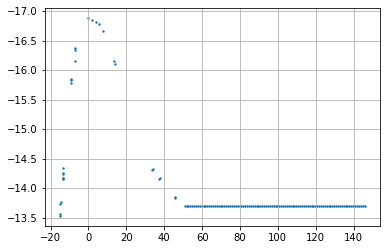

66


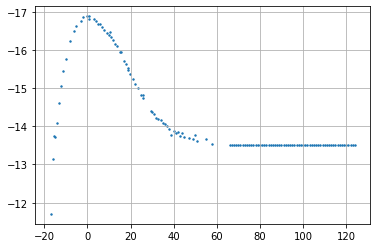

41


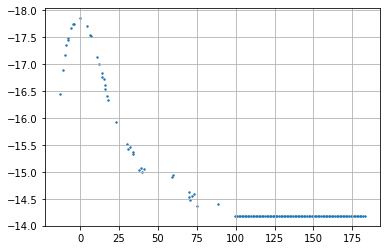

22


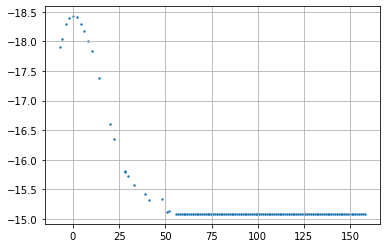

47


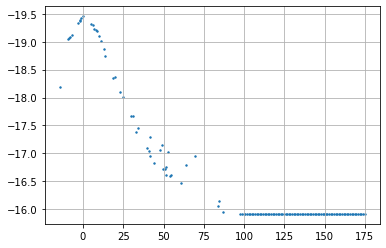

35


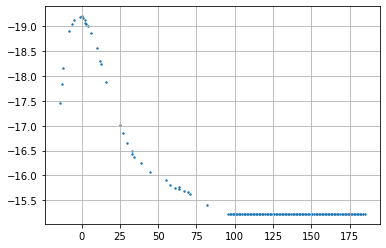

41


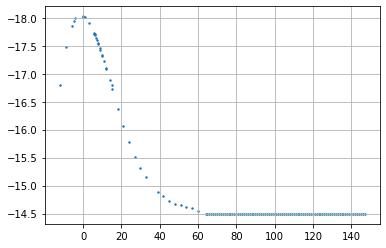

41


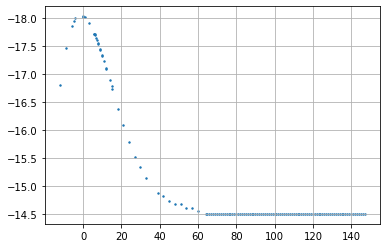

25


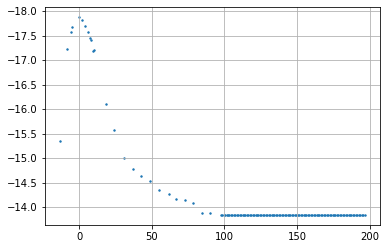

48


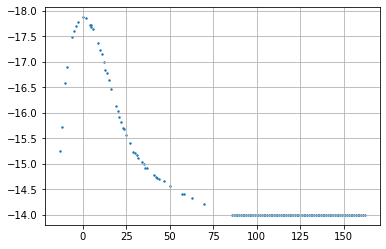

55


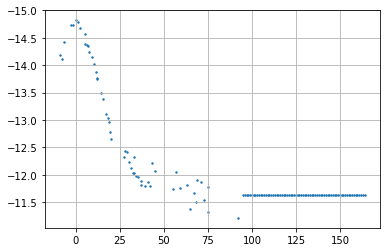

15


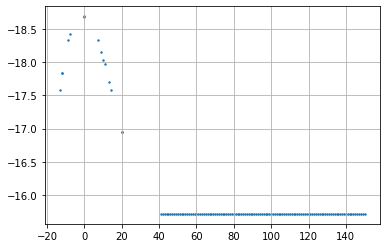

45


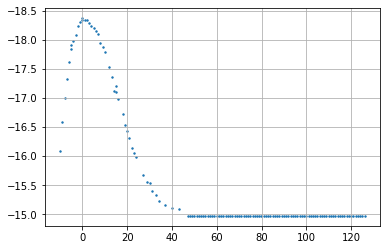

54


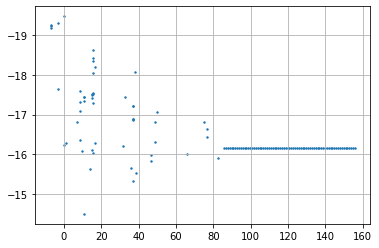

67


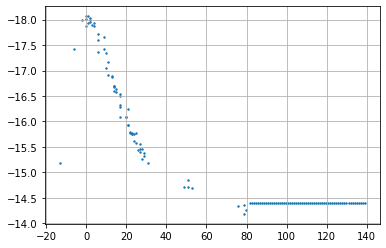

46


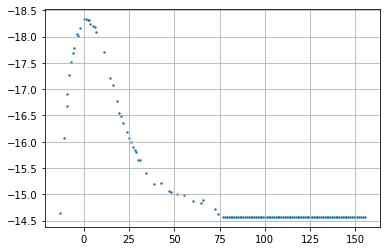

48


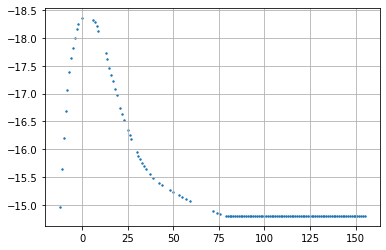

51


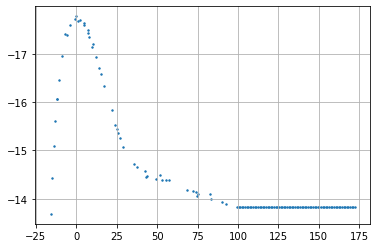

108


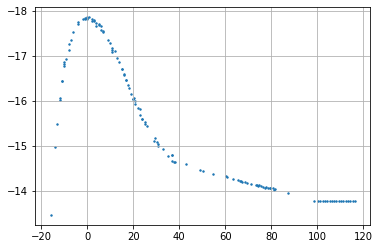

21


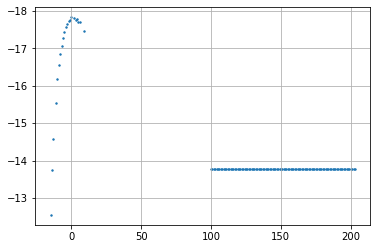

57


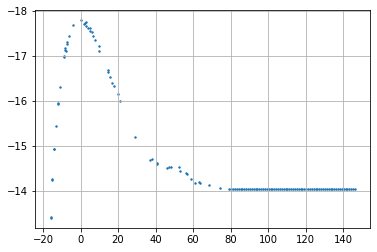

21


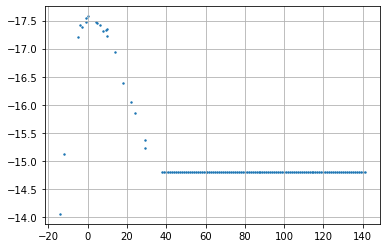

21


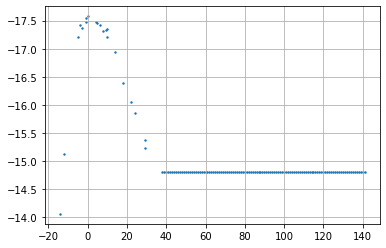

124


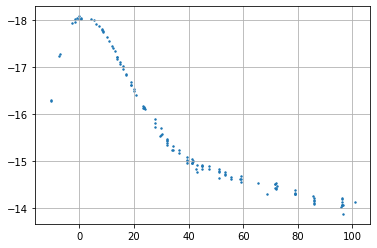

28


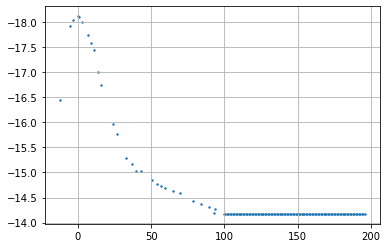

50


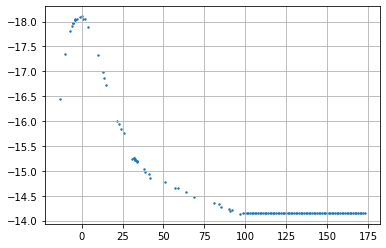

27


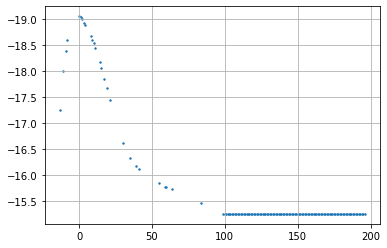

26


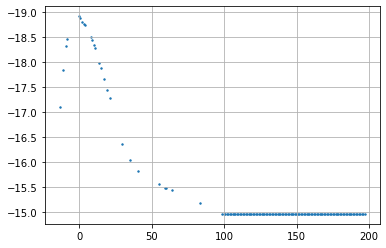

19


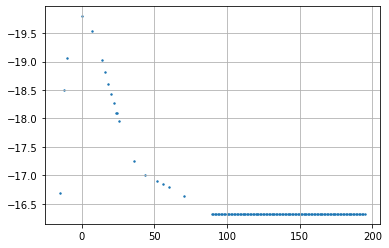

76


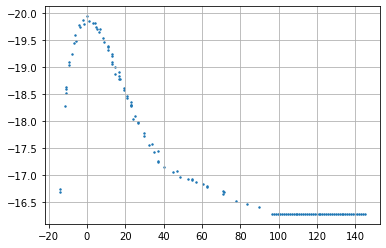

85


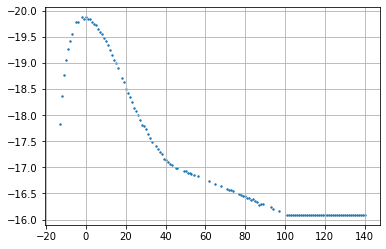

35


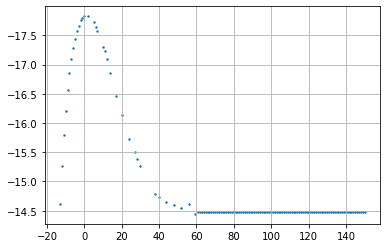

31


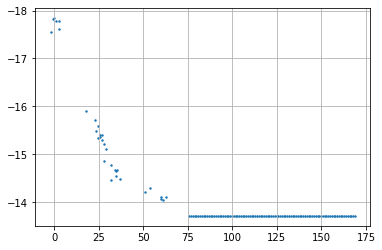

35


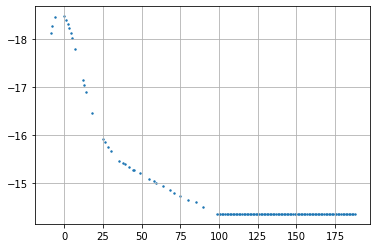

21


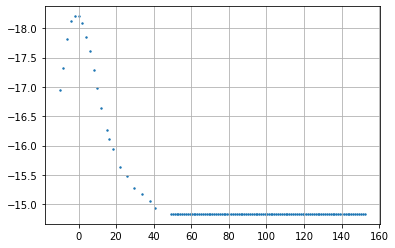

40


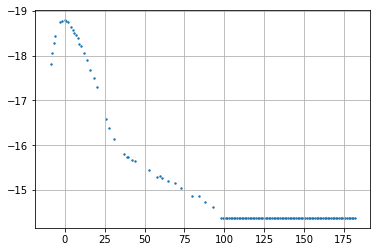

41


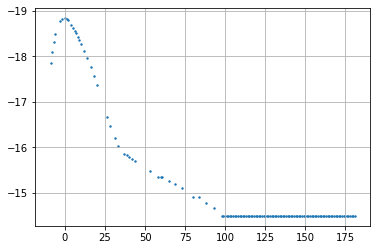

61


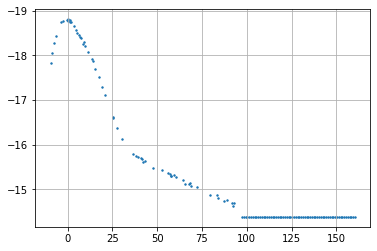

35


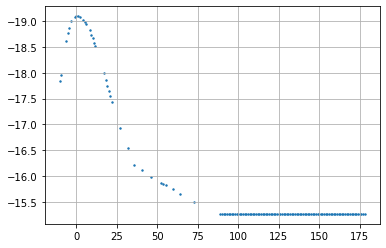

15


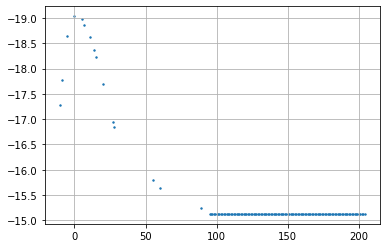

29


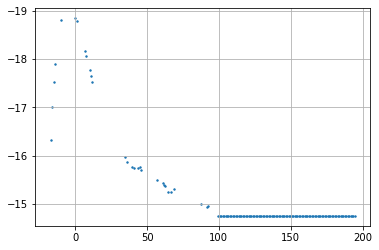

31


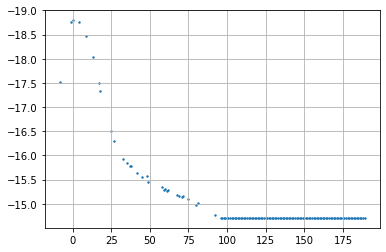

19


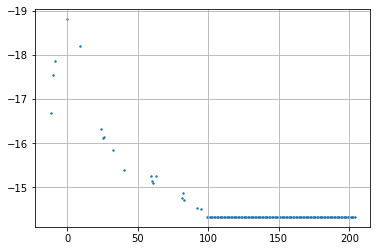

20


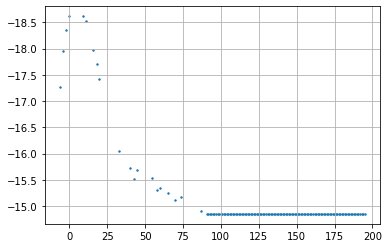

62


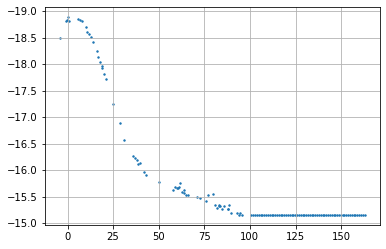

75


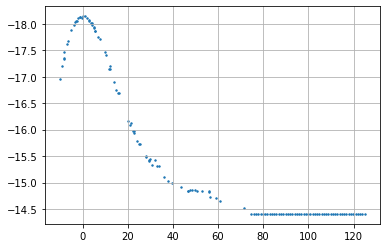

49


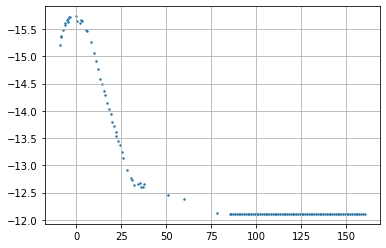

In [145]:
'''This cell serves as selecting suitable light curves,
and also padding of the suitable light curves therefore they all have the same length (no. of data points),
at the end this cell will return'''

data = [] # Store data to be used in the nueral network
lightcurve_length_max = 0 # Store the maximum light curve length
#lightcurve_length_max = 60
lightcurve_length = [] # Store the length of each light curve to calculate the no. of point to be padded
lightcurve_days = 100 # No. of days after the peak to be truncated to the data

lightcurve_succ = [] # Store the id of the exact lightcurves that are filtered
#Time_tail = []
#Magnitude_Abs_tail = []


# Data selection
for i in range(Sample_Count):
    
    if len(Time[i]) > 20: # Avoid lightcurve with too few data points
        
        #Time_tail.append([])
        #Magnitude_Abs_tail.append([])
        
        slope = 0
        
        for j in range(3): # Maybe try to use polynomial fit and check if minimum exist?
            slope += (Magnitude_Abs[i][j+1] - Magnitude_Abs[i][j]) / (Time[i][j+1] - Time[i][j]) # Calculate the average slope between 1st and 4th data point to select out data with rising peak only
            
        if slope < 0: # Choose lightcurve with a rising peak initially
            
            '''maximum = np.argmin(Magnitude_Abs[i])
            Time_tail[i] = Time[i][maximum:]
            Magnitude_Abs_tail[i] = Magnitude_Abs[i][maximum:]'''
            
            maximum = np.argmin(Magnitude_Abs[i]) # Find the id of the peak
            
            if (Time[i][-1] - Time[i][maximum]) > lightcurve_days: # Select lightcurves longer than 100 days after peak
                
                for j in range(len(Time[i])):
                    if ((Time[i][j] - Time[i][maximum]) > lightcurve_days):
                        
                        lightcurve_length.append(j-1) # Store the no. of data point of each lightcurve just before 100 days after peak
                        lightcurve_length_max = max([j, lightcurve_length_max]) # Obtain the maximum lightcurve length
                        lightcurve_succ.append(i) # Store the id of sample that is stored in data[[]]
                        break
                        
                        '''if lightcurve_length[-1] < lightcurve_length_max:
                            lightcurve_succ.append(i)
                        else:
                            del lightcurve_length[-1]
                        break'''
                        
                        
print('The maximum lightcurve length is', lightcurve_length_max)
print(lightcurve_succ)
print(lightcurve_length)
print(len(lightcurve_succ), len(lightcurve_length))

# Padding the lightcurve

t = []
m = []
t_temp = []
m_temp = []

for i in range(len(lightcurve_succ)):
    
    t.append([])
    m.append([])
    t_temp.append([])
    m_temp.append([])
    
    for j in range(lightcurve_length_max - lightcurve_length[i]):
        t_temp[i].append(Time[lightcurve_succ[i]][lightcurve_length[i]] - Time[lightcurve_succ[i]][0] + j + 1) # Padding days, +1 day after each datapoint after 100 days, -1
        m_temp[i].append(Magnitude_Abs[lightcurve_succ[i]][lightcurve_length[i]]) # Padding magnitude with the magnitude just before 100 days, -1
        #m_temp[i].append(Magnitude_Abs[lightcurve_succ[i]][lightcurve_length[i]] - 0.01*j)
        #m_temp[i].append(-10)
        
    t_temp2 = np.array(Time[lightcurve_succ[i]][0:lightcurve_length[i]]) # Physical data points
    t_temp2 = t_temp2[:] - Time[lightcurve_succ[i]][0] # Create a relative days
        
    t[i] = np.hstack((t_temp2, t_temp[i])) 
    m[i] = np.hstack((Magnitude_Abs[lightcurve_succ[i]][0:lightcurve_length[i]], m_temp[i]))
    
    # Shift the days to align the peaks to be at 0 day
    maximum = np.argmin(m[i])
    diff = t[i][maximum] - t[i][0]
    t[i] = t[i] - diff
    
    data.append([t[i], m[i]])


print('No. of data is', len(data))
    
# Print out the padded lightcurve
for i in range(len(data)):
    print(lightcurve_length[i])
    plt.gca().invert_yaxis()
    plt.grid()
    plt.scatter(data[i][0], data[i][1], s=2)
    plt.show()

In [146]:
# Spliting training set and testing set

split_portion = 0.6

data = np.array(data)
split = int(split_portion*len(data))
data_train = data[:split]
data_test = data[split:]
lightcurve_train = data_train.transpose((0, 2, 1)) 
lightcurve_test = data_test.transpose((0, 2, 1))

print(lightcurve_train.shape) #no. of sample (batch size), timesteps in RNN, no. of features
print(lightcurve_test.shape)

#plt.scatter(lightcurve_train[4,:,0], lightcurve_train[4,:,1], s=2)

(28, 125, 2)
(19, 125, 2)


In [7]:
'''# Interpolating the data

data = []
lightcurve_length_max = 0
lightcurve_length = []
lightcurve_succ = []
lightcurve_days = 130


# To obtain individual lightcurve length (timesteps length) and the maximum lightcurve length
for i in range(len(filename)):
    
    if len(Time[i]) > 65: # Avoid lightcurve with too few data points
        if (Time[i][-1] - Time[i][0]) > lightcurve_days:
            for j in range(len(Time[i])):
                if (Time[i][j] - Time[i][0]) > lightcurve_days:
                    lightcurve_length.append(j)
                    lightcurve_length_max = max([j, lightcurve_length_max])
                    lightcurve_succ.append(1)
                    break
        else:
            lightcurve_succ.append(0)
    else:
        lightcurve_succ.append(0)

print(lightcurve_length_max)
print(len(filename))
print(len(lightcurve_succ))
print(lightcurve_succ)
print(len(lightcurve_length))
print(lightcurve_length)

j = 0

steps = 150

for i in range(len(filename)):
    
    if lightcurve_succ[i] == 1:
        ''''''t_temp = np.array(Time[i]) 
        t = t_temp[:lightcurve_length[j]+1] - t_temp[0]
        print('no. of data points is', len(t))''''''
        print('the claimed type is', Type[i])
        t = np.linspace(0, lightcurve_length[j]+1, lightcurve_length[j]+1)
        print(len(t))
        m = Magnitude_Abs[i][:lightcurve_length[j]+1]
        print(len(m))
        f = interp1d(t, m)
        ''''''tnew = np.linspace(0, lightcurve_days, steps)''''''
        tnew = np.linspace(0, lightcurve_length[j]+1, steps)
        mnew = f(tnew)
        
        fig = plt.figure(figsize=(16,10))
        plt.gca().invert_yaxis()
        plt.grid()
        plt.scatter(t, m, s=2)
        plt.scatter(tnew, mnew, s=2)
        plt.show()
        
        data.append(mnew)
        j += 1'''

"# Interpolating the data\n\ndata = []\nlightcurve_length_max = 0\nlightcurve_length = []\nlightcurve_succ = []\nlightcurve_days = 130\n\n\n# To obtain individual lightcurve length (timesteps length) and the maximum lightcurve length\nfor i in range(len(filename)):\n    \n    if len(Time[i]) > 65: # Avoid lightcurve with too few data points\n        if (Time[i][-1] - Time[i][0]) > lightcurve_days:\n            for j in range(len(Time[i])):\n                if (Time[i][j] - Time[i][0]) > lightcurve_days:\n                    lightcurve_length.append(j)\n                    lightcurve_length_max = max([j, lightcurve_length_max])\n                    lightcurve_succ.append(1)\n                    break\n        else:\n            lightcurve_succ.append(0)\n    else:\n        lightcurve_succ.append(0)\n\nprint(lightcurve_length_max)\nprint(len(filename))\nprint(len(lightcurve_succ))\nprint(lightcurve_succ)\nprint(len(lightcurve_length))\nprint(lightcurve_length)\n\nj = 0\n\nsteps = 150\n\n

In [8]:
'''# Spliting training set and testing set

split_portion = 0.8

data = np.array(data)
split = int(split_portion*len(data))
data_train = data[:split]
data_test = data[split:]
lightcurve_train = data_train.reshape(len(data_train), steps, 1) #no. of sample (batch size), timesteps in RNN, no. of features
lightcurve_test = data_test.reshape(len(data_test), steps, 1)

print(lightcurve_train.shape)
print(lightcurve_test.shape)'''

'# Spliting training set and testing set\n\nsplit_portion = 0.8\n\ndata = np.array(data)\nsplit = int(split_portion*len(data))\ndata_train = data[:split]\ndata_test = data[split:]\nlightcurve_train = data_train.reshape(len(data_train), steps, 1) #no. of sample (batch size), timesteps in RNN, no. of features\nlightcurve_test = data_test.reshape(len(data_test), steps, 1)\n\nprint(lightcurve_train.shape)\nprint(lightcurve_test.shape)'

In [148]:
# Custom loss function weighting the non-padding part

weight = []
#for i in range(32):
for i in range(lightcurve_train.shape[0]):
    temp1 = [1 for j in range(lightcurve_length[i])]
    temp2 = [0 for j in range(lightcurve_train.shape[1]-lightcurve_length[i])]
    temp = np.hstack((temp1, temp2))
    weight.append(temp)
    weight1 = np.array(weight)
print(temp)
print(weight1.shape)

def my_loss_fn(y_true, y_pred):
    
    mse = tf.keras.losses.MeanSquaredError()
    return mse(y_true, y_pred, sample_weight=weight1)

print(my_loss_fn(lightcurve_train, 0.8*lightcurve_train))



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(28, 125)
tf.Tensor(10.883256912231445, shape=(), dtype=float64)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_36 (Bidirectio (None, 125, 500)          381000    
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 20)                30720     
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 125, 20)           0         
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 125, 500)          408000    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 125, 2)            1002      
Total params: 820,722
Trainable params: 820,722
Non-trainable params: 0
_________________________________________________________________


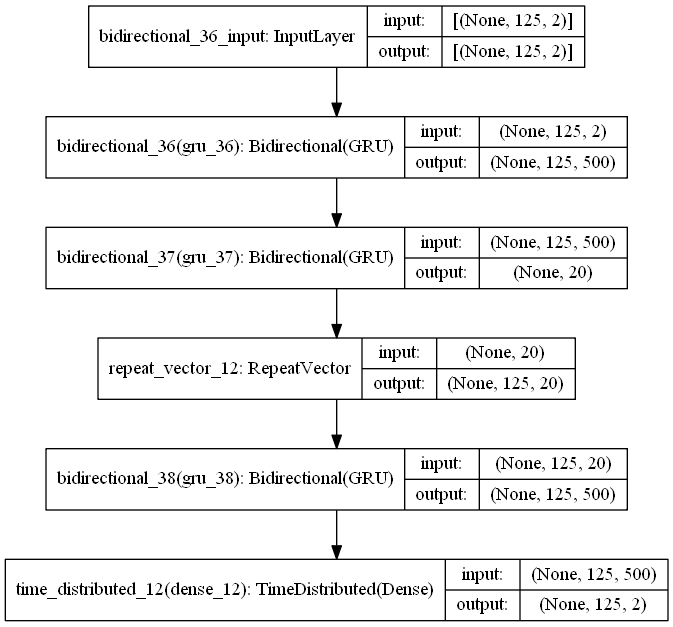

In [115]:
# define model
model = Sequential()
model.add(Bidirectional(GRU(250, activation='tanh', input_shape=(lightcurve_length_max, 2), return_sequences=True)))
model.add(Bidirectional(GRU(10, activation='tanh', return_sequences=False)))
model.add(RepeatVector(lightcurve_length_max))
model.add(Bidirectional(GRU(250, activation='tanh', return_sequences=True)))
model.add(TimeDistributed(Dense(2)))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=my_loss_fn)
model.build(input_shape=[None, lightcurve_length_max, 2])
model.summary()
plot_model(model, show_shapes=True)

In [116]:
# Fit model
#validation_split = 0.2
callbacks = EarlyStopping(monitor='loss', min_delta=1e-3, patience=30, restore_best_weights=True)
history = model.fit(lightcurve_train, lightcurve_train, epochs=4000, verbose=1)

Epoch 1/4000
1/1 [==============================] - 6s 6s/step - loss: 665.3770
Epoch 2/4000
1/1 [==============================] - 0s 59ms/step - loss: 611.6567
Epoch 3/4000
1/1 [==============================] - 0s 57ms/step - loss: 609.5419
Epoch 4/4000
1/1 [==============================] - 0s 59ms/step - loss: 647.4186
Epoch 5/4000
1/1 [==============================] - 0s 56ms/step - loss: 532.8895
Epoch 6/4000
1/1 [==============================] - 0s 54ms/step - loss: 499.6493
Epoch 7/4000
1/1 [==============================] - 0s 54ms/step - loss: 744.3586
Epoch 8/4000
1/1 [==============================] - 0s 53ms/step - loss: 711.4953
Epoch 9/4000
1/1 [==============================] - 0s 55ms/step - loss: 451.5442
Epoch 10/4000
1/1 [==============================] - 0s 49ms/step - loss: 350.2467
Epoch 11/4000
1/1 [==============================] - 0s 56ms/step - loss: 433.2996
Epoch 12/4000
1/1 [==============================] - 0s 54ms/step - loss: 400.9310
Epoch 13/4000
1

1/1 [==============================] - 0s 54ms/step - loss: 124.0630
Epoch 198/4000
1/1 [==============================] - 0s 55ms/step - loss: 98.0416
Epoch 199/4000
1/1 [==============================] - 0s 53ms/step - loss: 52.6005
Epoch 200/4000
1/1 [==============================] - 0s 54ms/step - loss: 99.1699
Epoch 201/4000
1/1 [==============================] - 0s 50ms/step - loss: 95.7910
Epoch 202/4000
1/1 [==============================] - 0s 54ms/step - loss: 54.2929
Epoch 203/4000
1/1 [==============================] - 0s 53ms/step - loss: 65.7880
Epoch 204/4000
1/1 [==============================] - 0s 46ms/step - loss: 141.2923
Epoch 205/4000
1/1 [==============================] - 0s 54ms/step - loss: 118.4622
Epoch 206/4000
1/1 [==============================] - 0s 52ms/step - loss: 48.0783
Epoch 207/4000
1/1 [==============================] - 0s 55ms/step - loss: 75.4969
Epoch 208/4000
1/1 [==============================] - 0s 55ms/step - loss: 45.5345
Epoch 209/4000
1

1/1 [==============================] - 0s 50ms/step - loss: 19.0103
Epoch 394/4000
1/1 [==============================] - 0s 49ms/step - loss: 14.1665
Epoch 395/4000
1/1 [==============================] - 0s 53ms/step - loss: 13.5160
Epoch 396/4000
1/1 [==============================] - 0s 54ms/step - loss: 14.5728
Epoch 397/4000
1/1 [==============================] - 0s 52ms/step - loss: 29.9242
Epoch 398/4000
1/1 [==============================] - 0s 45ms/step - loss: 26.5391
Epoch 399/4000
1/1 [==============================] - 0s 54ms/step - loss: 19.3248
Epoch 400/4000
1/1 [==============================] - 0s 54ms/step - loss: 12.7543
Epoch 401/4000
1/1 [==============================] - 0s 54ms/step - loss: 13.6190
Epoch 402/4000
1/1 [==============================] - 0s 54ms/step - loss: 19.9611
Epoch 403/4000
1/1 [==============================] - 0s 49ms/step - loss: 19.0814
Epoch 404/4000
1/1 [==============================] - 0s 44ms/step - loss: 12.2467
Epoch 405/4000
1/1 

Epoch 492/4000
1/1 [==============================] - 0s 55ms/step - loss: 34.4361
Epoch 493/4000
1/1 [==============================] - 0s 52ms/step - loss: 13.7392
Epoch 494/4000
1/1 [==============================] - 0s 46ms/step - loss: 11.6768
Epoch 495/4000
1/1 [==============================] - 0s 53ms/step - loss: 11.1228
Epoch 496/4000
1/1 [==============================] - 0s 53ms/step - loss: 27.5491
Epoch 497/4000
1/1 [==============================] - 0s 54ms/step - loss: 24.5924
Epoch 498/4000
1/1 [==============================] - 0s 46ms/step - loss: 16.6096
Epoch 499/4000
1/1 [==============================] - 0s 53ms/step - loss: 12.2736
Epoch 500/4000
1/1 [==============================] - 0s 54ms/step - loss: 16.0199
Epoch 501/4000
1/1 [==============================] - 0s 51ms/step - loss: 13.8801
Epoch 502/4000
1/1 [==============================] - 0s 54ms/step - loss: 24.2348
Epoch 503/4000
1/1 [==============================] - 0s 50ms/step - loss: 18.6902
Epoc

1/1 [==============================] - 0s 40ms/step - loss: 8.7834
Epoch 592/4000
1/1 [==============================] - 0s 47ms/step - loss: 22.2683
Epoch 593/4000
1/1 [==============================] - 0s 50ms/step - loss: 27.8794
Epoch 594/4000
1/1 [==============================] - 0s 47ms/step - loss: 14.0172
Epoch 595/4000
1/1 [==============================] - 0s 50ms/step - loss: 7.3057
Epoch 596/4000
1/1 [==============================] - 0s 49ms/step - loss: 9.1631
Epoch 597/4000
1/1 [==============================] - 0s 55ms/step - loss: 7.1165
Epoch 598/4000
1/1 [==============================] - 0s 54ms/step - loss: 7.5474
Epoch 599/4000
1/1 [==============================] - 0s 54ms/step - loss: 15.8898
Epoch 600/4000
1/1 [==============================] - 0s 54ms/step - loss: 21.7313
Epoch 601/4000
1/1 [==============================] - 0s 44ms/step - loss: 16.9161
Epoch 602/4000
1/1 [==============================] - 0s 54ms/step - loss: 14.6400
Epoch 603/4000
1/1 [====

1/1 [==============================] - 0s 56ms/step - loss: 6.5598
Epoch 790/4000
1/1 [==============================] - 0s 50ms/step - loss: 5.1572
Epoch 791/4000
1/1 [==============================] - 0s 49ms/step - loss: 4.7930
Epoch 792/4000
1/1 [==============================] - 0s 53ms/step - loss: 6.6052
Epoch 793/4000
1/1 [==============================] - 0s 50ms/step - loss: 10.9954
Epoch 794/4000
1/1 [==============================] - 0s 55ms/step - loss: 8.7983
Epoch 795/4000
1/1 [==============================] - 0s 53ms/step - loss: 7.9310
Epoch 796/4000
1/1 [==============================] - 0s 54ms/step - loss: 16.0224
Epoch 797/4000
1/1 [==============================] - 0s 54ms/step - loss: 4.7138
Epoch 798/4000
1/1 [==============================] - 0s 56ms/step - loss: 5.6858
Epoch 799/4000
1/1 [==============================] - 0s 57ms/step - loss: 4.9938
Epoch 800/4000
1/1 [==============================] - 0s 52ms/step - loss: 13.3394
Epoch 801/4000
1/1 [========

Epoch 988/4000
1/1 [==============================] - 0s 56ms/step - loss: 6.2435
Epoch 989/4000
1/1 [==============================] - 0s 55ms/step - loss: 8.6479
Epoch 990/4000
1/1 [==============================] - 0s 54ms/step - loss: 5.1625
Epoch 991/4000
1/1 [==============================] - 0s 54ms/step - loss: 5.2214
Epoch 992/4000
1/1 [==============================] - 0s 52ms/step - loss: 4.8191
Epoch 993/4000
1/1 [==============================] - 0s 45ms/step - loss: 4.6270
Epoch 994/4000
1/1 [==============================] - 0s 55ms/step - loss: 5.9187
Epoch 995/4000
1/1 [==============================] - 0s 55ms/step - loss: 12.3053
Epoch 996/4000
1/1 [==============================] - 0s 53ms/step - loss: 4.3684
Epoch 997/4000
1/1 [==============================] - 0s 57ms/step - loss: 3.8625
Epoch 998/4000
1/1 [==============================] - 0s 55ms/step - loss: 6.4734
Epoch 999/4000
1/1 [==============================] - 0s 52ms/step - loss: 6.1682
Epoch 1000/4000

1/1 [==============================] - 0s 55ms/step - loss: 4.4029
Epoch 1185/4000
1/1 [==============================] - 0s 51ms/step - loss: 3.0508
Epoch 1186/4000
1/1 [==============================] - 0s 47ms/step - loss: 4.3618
Epoch 1187/4000
1/1 [==============================] - 0s 49ms/step - loss: 3.3246
Epoch 1188/4000
1/1 [==============================] - 0s 53ms/step - loss: 2.8583
Epoch 1189/4000
1/1 [==============================] - 0s 49ms/step - loss: 2.5910
Epoch 1190/4000
1/1 [==============================] - 0s 45ms/step - loss: 9.3243
Epoch 1191/4000
1/1 [==============================] - 0s 51ms/step - loss: 3.0596
Epoch 1192/4000
1/1 [==============================] - 0s 56ms/step - loss: 2.7625
Epoch 1193/4000
1/1 [==============================] - 0s 52ms/step - loss: 3.4001
Epoch 1194/4000
1/1 [==============================] - 0s 52ms/step - loss: 9.2435
Epoch 1195/4000
1/1 [==============================] - 0s 53ms/step - loss: 3.0540
Epoch 1196/4000
1/1 

1/1 [==============================] - 0s 52ms/step - loss: 4.1816
Epoch 1381/4000
1/1 [==============================] - 0s 51ms/step - loss: 6.1190
Epoch 1382/4000
1/1 [==============================] - 0s 54ms/step - loss: 5.8278
Epoch 1383/4000
1/1 [==============================] - 0s 53ms/step - loss: 3.2451
Epoch 1384/4000
1/1 [==============================] - 0s 53ms/step - loss: 3.2878
Epoch 1385/4000
1/1 [==============================] - 0s 55ms/step - loss: 4.2862
Epoch 1386/4000
1/1 [==============================] - 0s 53ms/step - loss: 3.9547
Epoch 1387/4000
1/1 [==============================] - 0s 51ms/step - loss: 5.3080
Epoch 1388/4000
1/1 [==============================] - 0s 51ms/step - loss: 3.8760
Epoch 1389/4000
1/1 [==============================] - 0s 46ms/step - loss: 3.1679
Epoch 1390/4000
1/1 [==============================] - 0s 53ms/step - loss: 3.3759
Epoch 1391/4000
1/1 [==============================] - 0s 49ms/step - loss: 4.4667
Epoch 1392/4000
1/1 

1/1 [==============================] - 0s 55ms/step - loss: 5.5891
Epoch 1577/4000
1/1 [==============================] - 0s 49ms/step - loss: 3.9295
Epoch 1578/4000
1/1 [==============================] - 0s 49ms/step - loss: 4.0416
Epoch 1579/4000
1/1 [==============================] - 0s 54ms/step - loss: 3.0411
Epoch 1580/4000
1/1 [==============================] - 0s 54ms/step - loss: 5.6992
Epoch 1581/4000
1/1 [==============================] - 0s 45ms/step - loss: 4.9790
Epoch 1582/4000
1/1 [==============================] - 0s 54ms/step - loss: 3.2273
Epoch 1583/4000
1/1 [==============================] - 0s 54ms/step - loss: 5.0302
Epoch 1584/4000
1/1 [==============================] - 0s 53ms/step - loss: 3.3388
Epoch 1585/4000
1/1 [==============================] - 0s 54ms/step - loss: 2.9324
Epoch 1586/4000
1/1 [==============================] - 0s 49ms/step - loss: 3.1275
Epoch 1587/4000
1/1 [==============================] - 0s 55ms/step - loss: 2.6186
Epoch 1588/4000
1/1 

1/1 [==============================] - 0s 54ms/step - loss: 1.6082
Epoch 1773/4000
1/1 [==============================] - 0s 55ms/step - loss: 2.4275
Epoch 1774/4000
1/1 [==============================] - 0s 53ms/step - loss: 1.5919
Epoch 1775/4000
1/1 [==============================] - 0s 52ms/step - loss: 2.1019
Epoch 1776/4000
1/1 [==============================] - 0s 48ms/step - loss: 1.9799
Epoch 1777/4000
1/1 [==============================] - 0s 55ms/step - loss: 4.4528
Epoch 1778/4000
1/1 [==============================] - 0s 51ms/step - loss: 1.8285
Epoch 1779/4000
1/1 [==============================] - 0s 49ms/step - loss: 3.3282
Epoch 1780/4000
1/1 [==============================] - 0s 54ms/step - loss: 2.3284
Epoch 1781/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.8512
Epoch 1782/4000
1/1 [==============================] - 0s 52ms/step - loss: 2.0080
Epoch 1783/4000
1/1 [==============================] - 0s 43ms/step - loss: 2.0365
Epoch 1784/4000
1/1 

1/1 [==============================] - 0s 55ms/step - loss: 2.8655
Epoch 1969/4000
1/1 [==============================] - 0s 55ms/step - loss: 1.9791
Epoch 1970/4000
1/1 [==============================] - 0s 53ms/step - loss: 2.0063
Epoch 1971/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.9396
Epoch 1972/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.9769
Epoch 1973/4000
1/1 [==============================] - 0s 53ms/step - loss: 1.8455
Epoch 1974/4000
1/1 [==============================] - 0s 51ms/step - loss: 1.9127
Epoch 1975/4000
1/1 [==============================] - 0s 46ms/step - loss: 3.3092
Epoch 1976/4000
1/1 [==============================] - 0s 49ms/step - loss: 2.0243
Epoch 1977/4000
1/1 [==============================] - 0s 51ms/step - loss: 2.1296
Epoch 1978/4000
1/1 [==============================] - 0s 49ms/step - loss: 2.8014
Epoch 1979/4000
1/1 [==============================] - 0s 48ms/step - loss: 1.6843
Epoch 1980/4000
1/1 

1/1 [==============================] - 0s 46ms/step - loss: 1.7454
Epoch 2165/4000
1/1 [==============================] - 0s 50ms/step - loss: 2.5683
Epoch 2166/4000
1/1 [==============================] - 0s 50ms/step - loss: 1.5617
Epoch 2167/4000
1/1 [==============================] - 0s 55ms/step - loss: 2.0848
Epoch 2168/4000
1/1 [==============================] - 0s 50ms/step - loss: 1.6006
Epoch 2169/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.7237
Epoch 2170/4000
1/1 [==============================] - 0s 56ms/step - loss: 1.7397
Epoch 2171/4000
1/1 [==============================] - 0s 52ms/step - loss: 1.6021
Epoch 2172/4000
1/1 [==============================] - 0s 55ms/step - loss: 2.1461
Epoch 2173/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.6803
Epoch 2174/4000
1/1 [==============================] - 0s 53ms/step - loss: 2.0993
Epoch 2175/4000
1/1 [==============================] - 0s 55ms/step - loss: 2.5997
Epoch 2176/4000
1/1 

1/1 [==============================] - 0s 55ms/step - loss: 1.4036
Epoch 2361/4000
1/1 [==============================] - 0s 53ms/step - loss: 1.6643
Epoch 2362/4000
1/1 [==============================] - 0s 52ms/step - loss: 2.7722
Epoch 2363/4000
1/1 [==============================] - 0s 55ms/step - loss: 1.5463
Epoch 2364/4000
1/1 [==============================] - 0s 50ms/step - loss: 1.4411
Epoch 2365/4000
1/1 [==============================] - 0s 53ms/step - loss: 1.8089
Epoch 2366/4000
1/1 [==============================] - 0s 52ms/step - loss: 1.2359
Epoch 2367/4000
1/1 [==============================] - 0s 47ms/step - loss: 1.4982
Epoch 2368/4000
1/1 [==============================] - 0s 56ms/step - loss: 1.6929
Epoch 2369/4000
1/1 [==============================] - 0s 44ms/step - loss: 1.1010
Epoch 2370/4000
1/1 [==============================] - 0s 50ms/step - loss: 1.3191
Epoch 2371/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.7143
Epoch 2372/4000
1/1 

1/1 [==============================] - 0s 53ms/step - loss: 1.1980
Epoch 2557/4000
1/1 [==============================] - 0s 54ms/step - loss: 2.5842
Epoch 2558/4000
1/1 [==============================] - 0s 56ms/step - loss: 1.5998
Epoch 2559/4000
1/1 [==============================] - 0s 53ms/step - loss: 1.4655
Epoch 2560/4000
1/1 [==============================] - 0s 59ms/step - loss: 1.5054
Epoch 2561/4000
1/1 [==============================] - 0s 53ms/step - loss: 1.3542
Epoch 2562/4000
1/1 [==============================] - 0s 52ms/step - loss: 1.5632
Epoch 2563/4000
1/1 [==============================] - 0s 55ms/step - loss: 1.8656
Epoch 2564/4000
1/1 [==============================] - 0s 55ms/step - loss: 1.3952
Epoch 2565/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.4937
Epoch 2566/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.4827
Epoch 2567/4000
1/1 [==============================] - 0s 50ms/step - loss: 1.8214
Epoch 2568/4000
1/1 

1/1 [==============================] - 0s 50ms/step - loss: 2.6587
Epoch 2753/4000
1/1 [==============================] - 0s 53ms/step - loss: 1.9135
Epoch 2754/4000
1/1 [==============================] - 0s 53ms/step - loss: 2.6353
Epoch 2755/4000
1/1 [==============================] - 0s 55ms/step - loss: 1.9163
Epoch 2756/4000
1/1 [==============================] - 0s 54ms/step - loss: 2.4745
Epoch 2757/4000
1/1 [==============================] - 0s 45ms/step - loss: 1.6537
Epoch 2758/4000
1/1 [==============================] - 0s 51ms/step - loss: 2.3274
Epoch 2759/4000
1/1 [==============================] - 0s 47ms/step - loss: 1.6539
Epoch 2760/4000
1/1 [==============================] - 0s 40ms/step - loss: 3.4429
Epoch 2761/4000
1/1 [==============================] - 0s 47ms/step - loss: 1.4550
Epoch 2762/4000
1/1 [==============================] - 0s 49ms/step - loss: 2.9401
Epoch 2763/4000
1/1 [==============================] - 0s 46ms/step - loss: 1.9533
Epoch 2764/4000
1/1 

1/1 [==============================] - 0s 51ms/step - loss: 1.6361
Epoch 2949/4000
1/1 [==============================] - 0s 51ms/step - loss: 2.1259
Epoch 2950/4000
1/1 [==============================] - 0s 47ms/step - loss: 1.7570
Epoch 2951/4000
1/1 [==============================] - 0s 40ms/step - loss: 1.9613
Epoch 2952/4000
1/1 [==============================] - 0s 45ms/step - loss: 1.9355
Epoch 2953/4000
1/1 [==============================] - 0s 51ms/step - loss: 1.9310
Epoch 2954/4000
1/1 [==============================] - 0s 54ms/step - loss: 2.1254
Epoch 2955/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.7787
Epoch 2956/4000
1/1 [==============================] - 0s 49ms/step - loss: 1.6741
Epoch 2957/4000
1/1 [==============================] - 0s 53ms/step - loss: 2.1951
Epoch 2958/4000
1/1 [==============================] - 0s 51ms/step - loss: 1.7051
Epoch 2959/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.9122
Epoch 2960/4000
1/1 

1/1 [==============================] - 0s 56ms/step - loss: 1.8336
Epoch 3145/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.4428
Epoch 3146/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.9774
Epoch 3147/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.9784
Epoch 3148/4000
1/1 [==============================] - 0s 48ms/step - loss: 1.7202
Epoch 3149/4000
1/1 [==============================] - 0s 56ms/step - loss: 1.1465
Epoch 3150/4000
1/1 [==============================] - 0s 54ms/step - loss: 2.0803
Epoch 3151/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.2118
Epoch 3152/4000
1/1 [==============================] - 0s 54ms/step - loss: 2.5026
Epoch 3153/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.7374
Epoch 3154/4000
1/1 [==============================] - 0s 53ms/step - loss: 1.7090
Epoch 3155/4000
1/1 [==============================] - 0s 56ms/step - loss: 1.8947
Epoch 3156/4000
1/1 

1/1 [==============================] - 0s 54ms/step - loss: 1.6052
Epoch 3341/4000
1/1 [==============================] - 0s 53ms/step - loss: 2.5017
Epoch 3342/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.2342
Epoch 3343/4000
1/1 [==============================] - 0s 54ms/step - loss: 2.1636
Epoch 3344/4000
1/1 [==============================] - 0s 46ms/step - loss: 1.9376
Epoch 3345/4000
1/1 [==============================] - 0s 49ms/step - loss: 1.5122
Epoch 3346/4000
1/1 [==============================] - 0s 47ms/step - loss: 1.3845
Epoch 3347/4000
1/1 [==============================] - 0s 52ms/step - loss: 2.0395
Epoch 3348/4000
1/1 [==============================] - 0s 52ms/step - loss: 1.9945
Epoch 3349/4000
1/1 [==============================] - 0s 53ms/step - loss: 1.3079
Epoch 3350/4000
1/1 [==============================] - 0s 56ms/step - loss: 2.2333
Epoch 3351/4000
1/1 [==============================] - 0s 49ms/step - loss: 1.8021
Epoch 3352/4000
1/1 

1/1 [==============================] - 0s 55ms/step - loss: 2.4675
Epoch 3537/4000
1/1 [==============================] - 0s 54ms/step - loss: 2.3798
Epoch 3538/4000
1/1 [==============================] - 0s 56ms/step - loss: 1.8690
Epoch 3539/4000
1/1 [==============================] - 0s 45ms/step - loss: 2.2260
Epoch 3540/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.7486
Epoch 3541/4000
1/1 [==============================] - 0s 54ms/step - loss: 4.0570
Epoch 3542/4000
1/1 [==============================] - 0s 49ms/step - loss: 2.3434
Epoch 3543/4000
1/1 [==============================] - 0s 49ms/step - loss: 2.5582
Epoch 3544/4000
1/1 [==============================] - 0s 48ms/step - loss: 1.9228
Epoch 3545/4000
1/1 [==============================] - 0s 51ms/step - loss: 2.8182
Epoch 3546/4000
1/1 [==============================] - 0s 51ms/step - loss: 2.0980
Epoch 3547/4000
1/1 [==============================] - 0s 51ms/step - loss: 2.6608
Epoch 3548/4000
1/1 

1/1 [==============================] - 0s 48ms/step - loss: 0.8761
Epoch 3733/4000
1/1 [==============================] - 0s 44ms/step - loss: 1.0212
Epoch 3734/4000
1/1 [==============================] - 0s 47ms/step - loss: 0.9877
Epoch 3735/4000
1/1 [==============================] - 0s 46ms/step - loss: 1.0113
Epoch 3736/4000
1/1 [==============================] - 0s 53ms/step - loss: 1.1840
Epoch 3737/4000
1/1 [==============================] - 0s 52ms/step - loss: 1.2432
Epoch 3738/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.0037
Epoch 3739/4000
1/1 [==============================] - 0s 46ms/step - loss: 0.9873
Epoch 3740/4000
1/1 [==============================] - 0s 53ms/step - loss: 1.0452
Epoch 3741/4000
1/1 [==============================] - 0s 52ms/step - loss: 0.9032
Epoch 3742/4000
1/1 [==============================] - 0s 54ms/step - loss: 0.9344
Epoch 3743/4000
1/1 [==============================] - 0s 54ms/step - loss: 0.9901
Epoch 3744/4000
1/1 

1/1 [==============================] - 0s 53ms/step - loss: 1.0998
Epoch 3929/4000
1/1 [==============================] - 0s 48ms/step - loss: 1.0706
Epoch 3930/4000
1/1 [==============================] - 0s 54ms/step - loss: 1.2714
Epoch 3931/4000
1/1 [==============================] - 0s 55ms/step - loss: 1.1142
Epoch 3932/4000
1/1 [==============================] - 0s 55ms/step - loss: 1.2926
Epoch 3933/4000
1/1 [==============================] - 0s 52ms/step - loss: 0.9319
Epoch 3934/4000
1/1 [==============================] - 0s 55ms/step - loss: 0.9954
Epoch 3935/4000
1/1 [==============================] - 0s 54ms/step - loss: 0.8733
Epoch 3936/4000
1/1 [==============================] - 0s 54ms/step - loss: 0.9440
Epoch 3937/4000
1/1 [==============================] - 0s 53ms/step - loss: 1.4969
Epoch 3938/4000
1/1 [==============================] - 0s 55ms/step - loss: 1.3946
Epoch 3939/4000
1/1 [==============================] - 0s 55ms/step - loss: 0.8850
Epoch 3940/4000
1/1 

(0.0, 20.0)

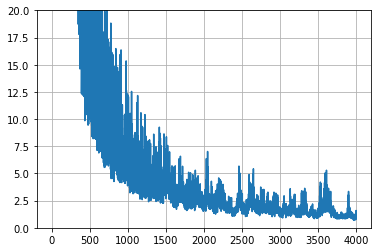

In [117]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.grid()
plt.ylim(0, 20)

In [118]:
# Delete the training set to save some ram
'''del(lightcurve_train)
del(data_train)'''

# Demonstrate recreation
yhat = model.predict(lightcurve_test, verbose=1)
#yhat_loss = model.evaluate(lightcurve_test, lightcurve_test, verbose=1)
yhat1 = model.predict(yhat, verbose=1)
print(len(yhat[4,:,1]))

1/1 [==============================] - 0s 20ms/step
125


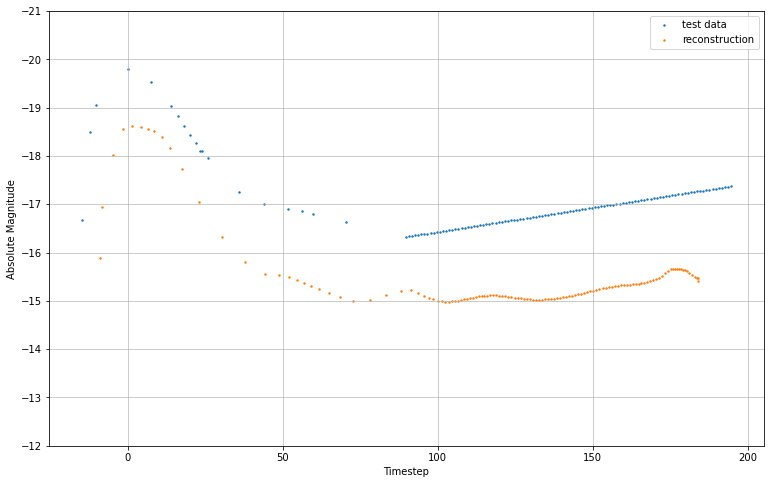

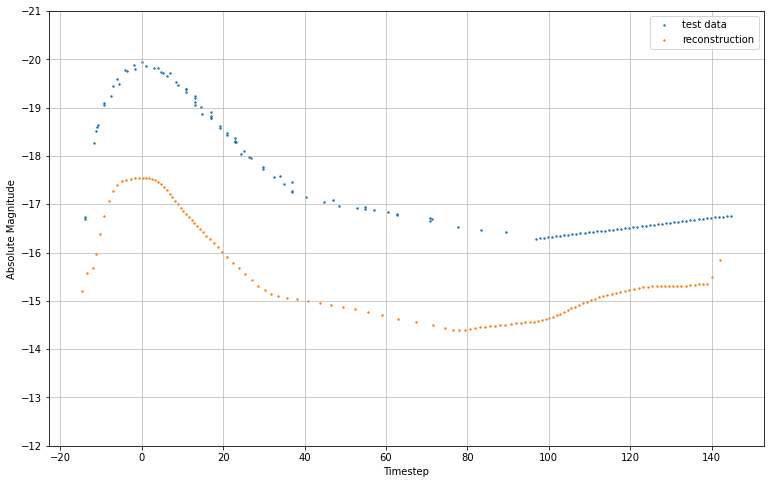

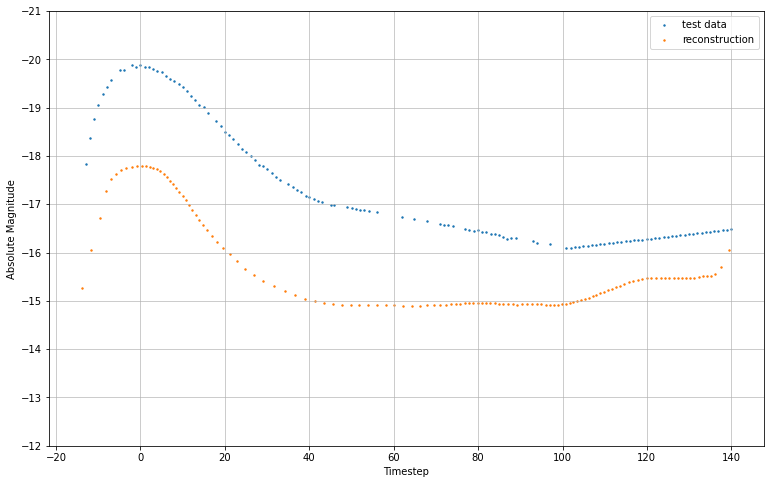

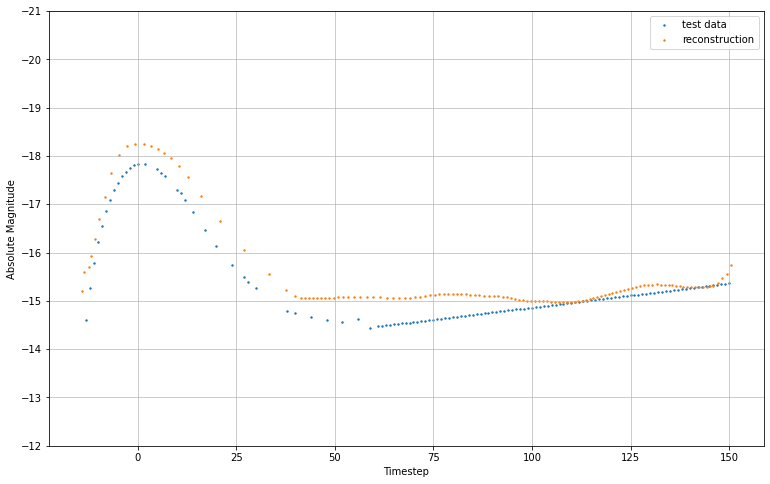

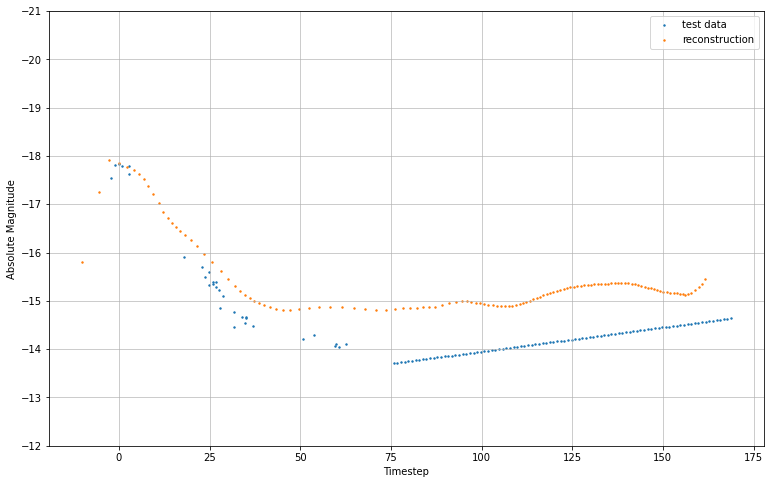

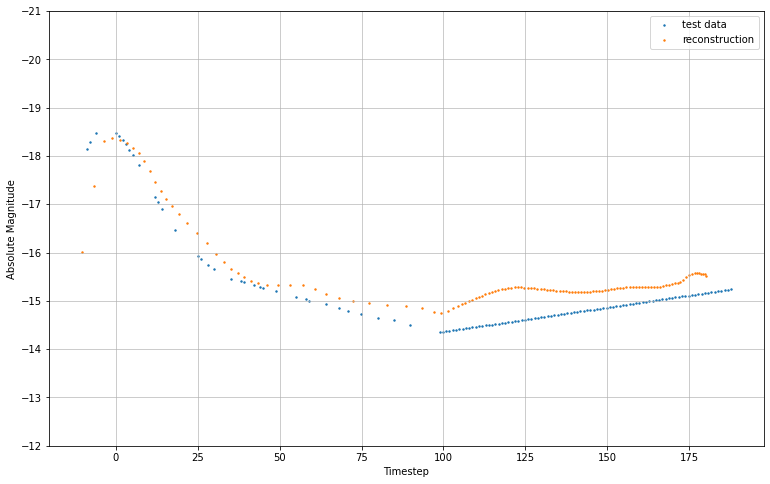

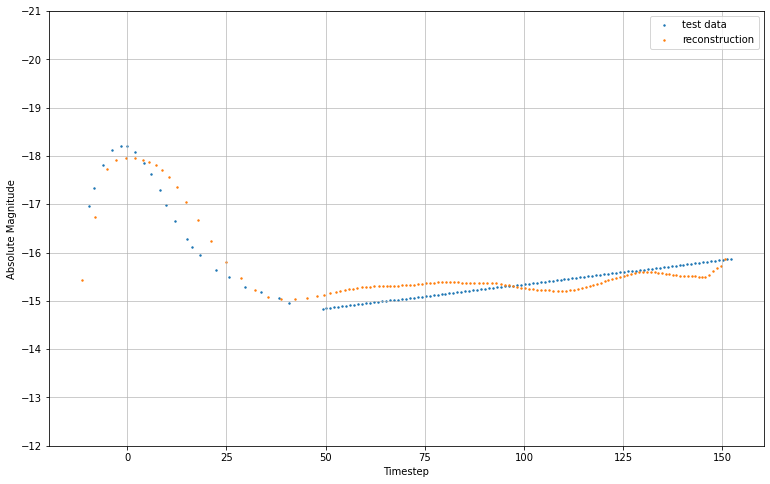

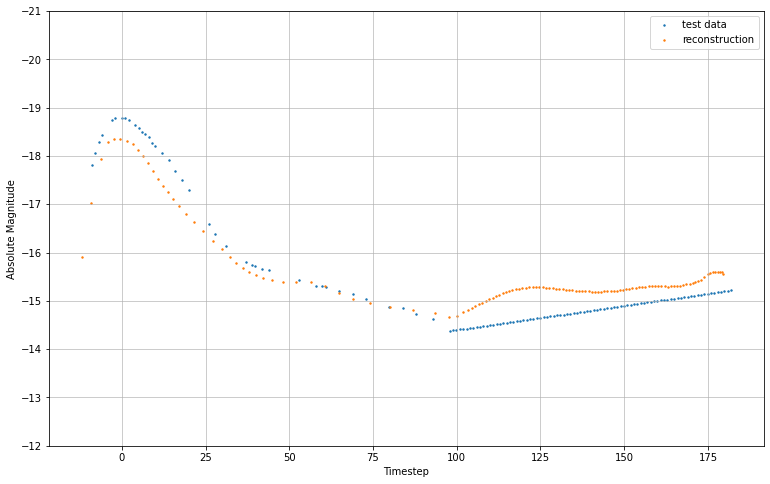

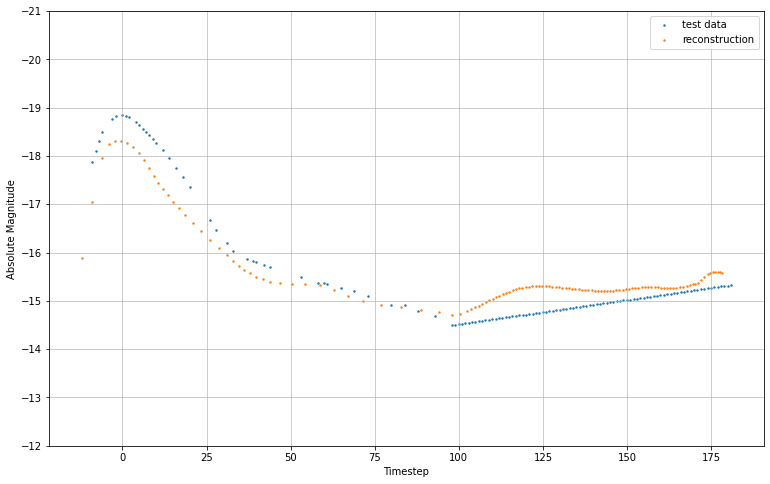

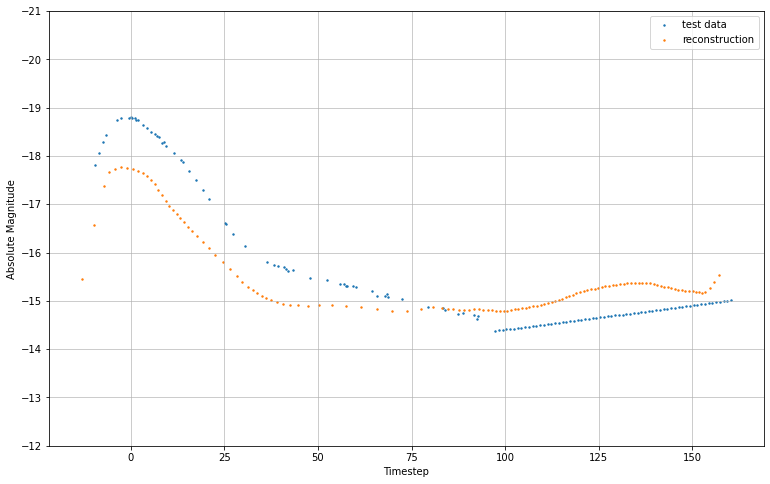

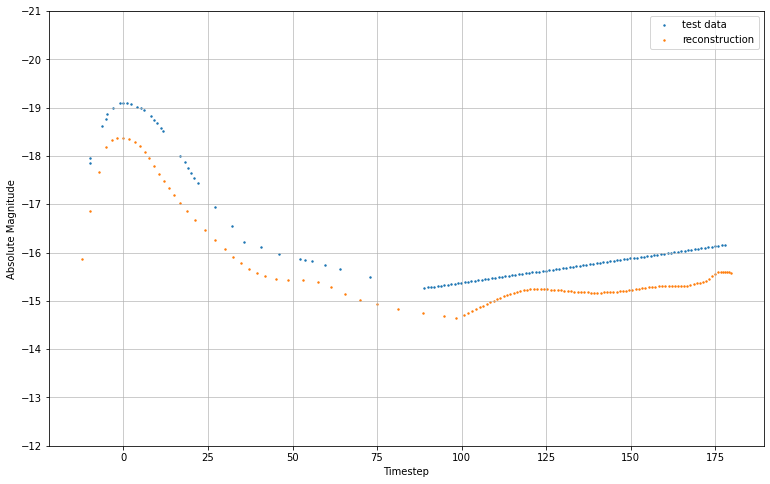

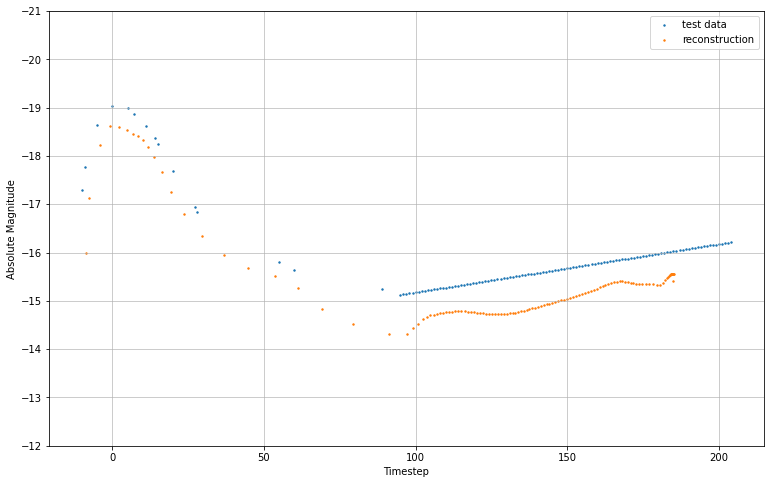

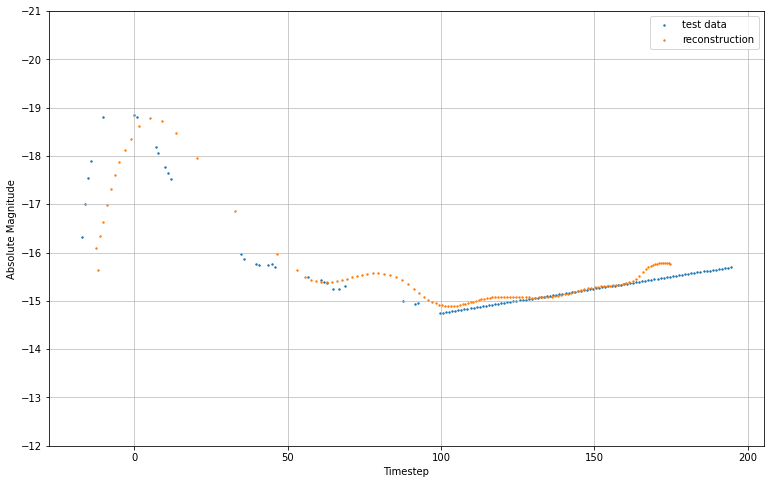

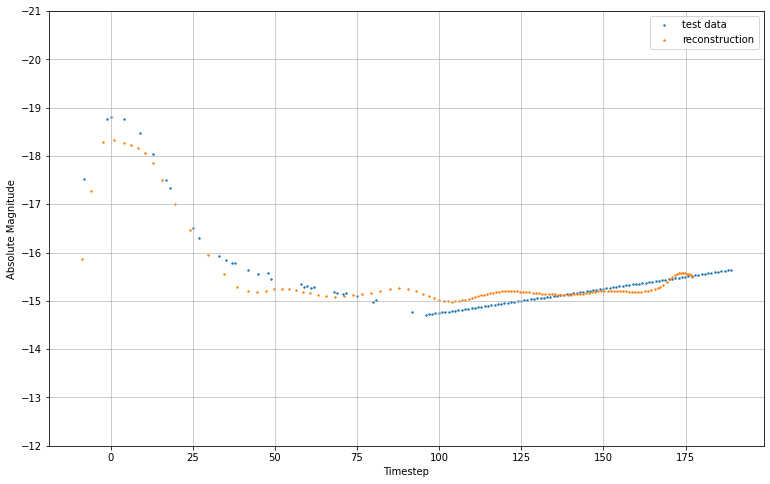

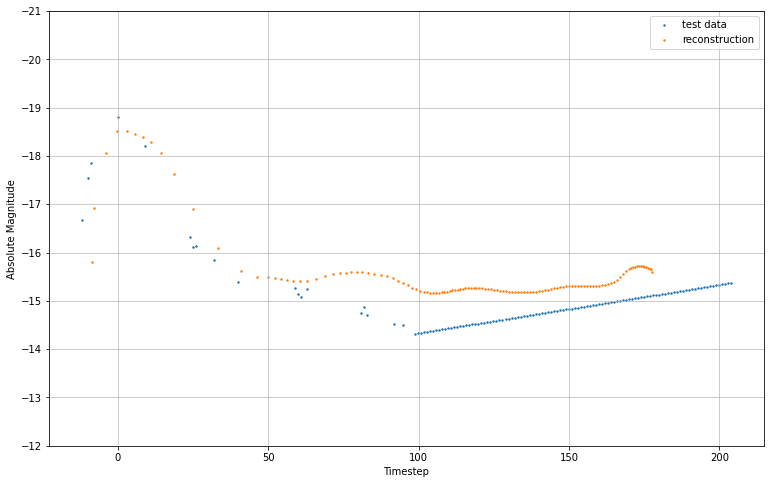

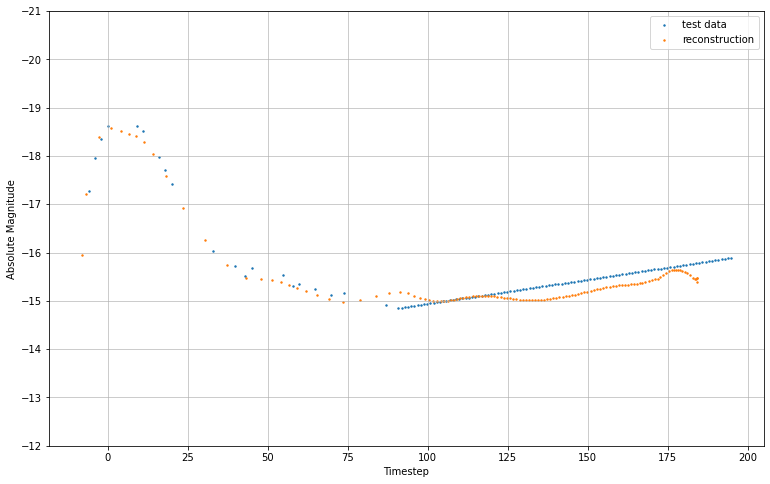

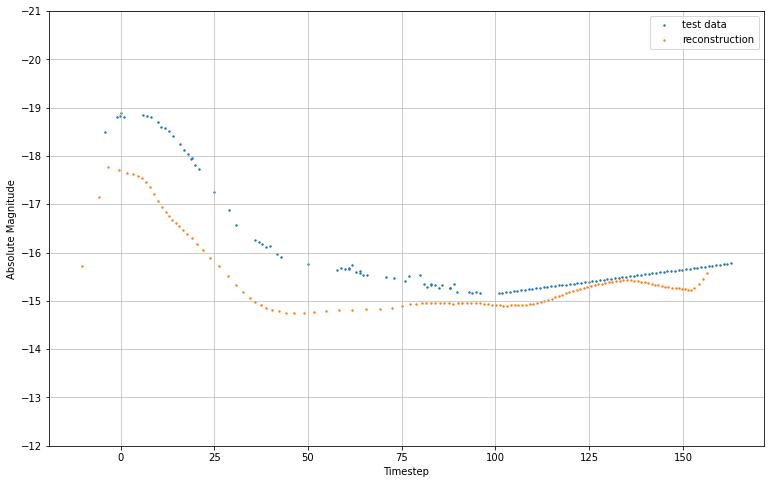

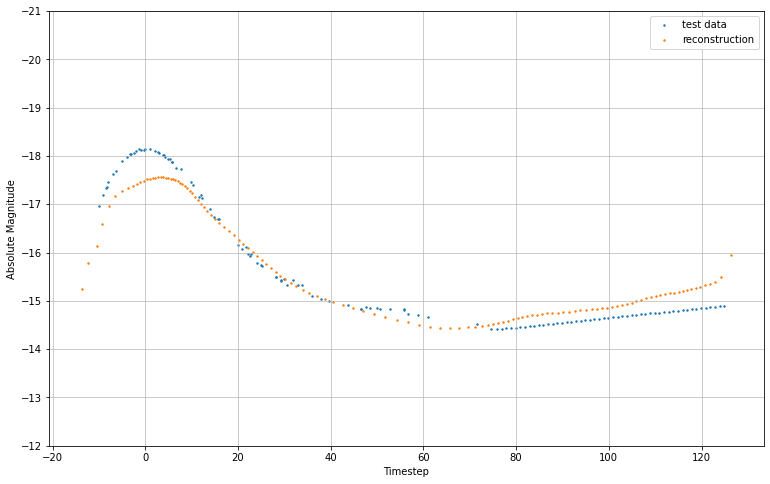

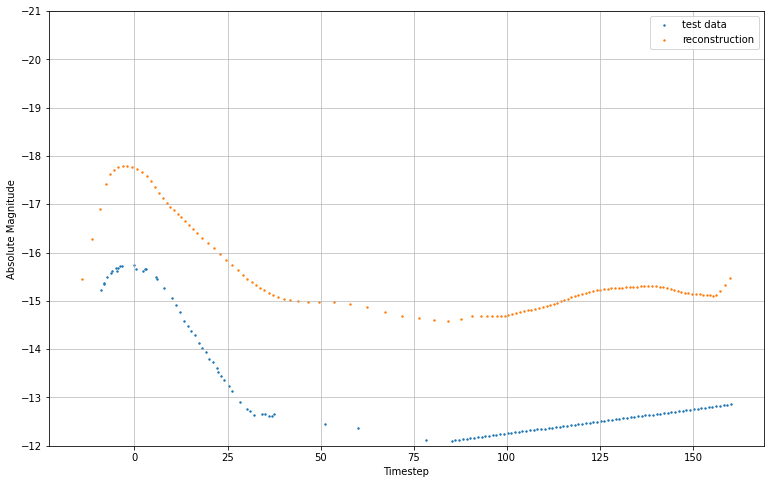

In [120]:
j = 0
path = r"C:\Users\ricky\JupyterNotebooks\Intern21\import_photometry_data\typeIa_photometry\data_test_physical_length100_shifted_weighteda_{}".format(lightcurve_length_max)
os.mkdir(path)
os.chdir(path)

for i in range(len(data_test)):
    fig = plt.figure(figsize=(12.8,8))
    ax = fig.add_subplot(1, 1, 1)

    plt.gca().invert_yaxis()

    # And a corresponding grid
    ax.grid(which='major', alpha=0.8)
    ax.grid(which='minor', alpha=0.3)

    plt.xlabel('Timestep')
    plt.ylabel('Absolute Magnitude')
    
    plt.ylim(-12, -21)

    '''x = np.linspace(1, lightcurve_length_max, lightcurve_length_max)

    plt.scatter(x, lightcurve_test[j,:,0], s=2)
    plt.scatter(x, yhat[j,:,0], s=2)'''
    
    plt.scatter(lightcurve_test[j,:,0], lightcurve_test[j,:,1], s=2, label='test data')
    plt.scatter(yhat[j,:,0], yhat[j,:,1], s=2, label='reconstruction')
    
    plt.legend()
        
    #print('the claimed type is', Type[i+split]) # This line is incorrect for now
    plt.savefig('{}.png'.format(i))    
    plt.show()
   
        
    j += 1

 
0.6724 x - 18.86
0.33143008114908834


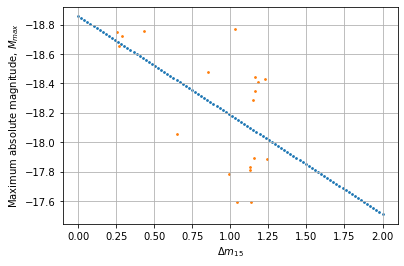

In [149]:
# Philips relation

from sklearn.metrics import r2_score
M = []
dm_P = []

fitting_days = 15

for i in range(len(data_test)): # Loop through all SN
    maximum = np.argmin(yhat[i,:,1]) # Find the id of maximum magnitude
    peak_time = yhat[i,maximum,0] # Save the day of maximum magnitude
    tail_time = yhat[i,maximum,0] # Save the day of the end of the initial lightcurve fall off
        
        # Calculate the day of the end of the initial lightcurve fall off
    j = 0
    if (peak_time + fitting_days) < yhat[i,-1,0]: # Avoid light curve that is too short (fewer than 15 days after the peak)
        while tail_time < (peak_time + fitting_days):
            tail_time = yhat[i,maximum+j,0]
            if tail_time > (peak_time + fitting_days):
                break
            j += 1
        
        # Save the peaking part of the light curve
        t = yhat[i,0:maximum+j,0]
        m = yhat[i,0:maximum+j,1]
        
        # Polynomial (degree = 3) fit of the peak part of the light curve 
        P = np.poly1d(np.polyfit(t, m, deg = 3))
        P_max = (-1*P[2] + ((P[2])**2 - 3*P[3]*P[1])**(1/2))/(3*P[3])
        
        M.append(P(P_max))
        dm_P.append(P(P_max + 15) - P(P_max))

#P1 = np.poly1d(np.polyfit(dm_P, M, deg = 1))
P1 = np.poly1d(np.polyfit(dm_P, M, deg = 1))
print(P1)
print(r2_score(M, P1(dm_P)))

# Plot out the linear relationship
plt.gca().invert_yaxis()
plt.xlabel('$\Delta m_{15}$')
plt.ylabel('Maximum absolute magnitude, $M_{max}$')
plt.grid()
x = np.linspace(0, 2, 100)
plt.scatter(x, P1(x), s=3)
plt.scatter(dm_P, M, s=3)